In [1]:
import os

import pandas as pd
import numpy as np

import urllib
from urllib.request import urlopen
import json
import requests

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from fbprophet import Prophet

In [2]:
def get_apple_link():
    """Get link of Apple Mobility Trends report file
    Output:
        data_link (str): link of Apple Mobility Trends report file
        data_name (str): name of Apple Mobility Trends report file
    """
    # get link via API
    link = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/v3/index.json"
    with urlopen(link) as url:
        json_data = json.loads(url.read().decode())
        pass
    # get link components from json dictionary
    basePath = json_data["basePath"]
    csvPath = json_data["regions"]["en-us"]["csvPath"]
    # aggregate to produce file link
    file_link = ("https://covid19-static.cdn-apple.com" + basePath + csvPath)
    # get file name
    file_name = file_link.rsplit('/', 1)[-1]
    
    return file_link, file_name

def save_file(data_directory = 'data'):
    """Check for updates and download the Trends report
    Input:
        data_directory (str): directory for saving the data
    Output:
        new_file_path (str): file path of most recently downloaded data
    """
    # create a data directory if it does not already exist
    directory = data_directory
    if not os.path.exists(directory):
        os.mkdir(directory)
        pass
    
    # get new file link and file name
    data_link, data_name = get_apple_link()
    
    # remove eveything in the data directory
    all_files = os.listdir(directory)
    [os.remove(os.path.join(directory, f)) for f in all_files]
    # save new data into the data directory
    new_file_path = os.path.join(directory, data_name)
    urllib.request.urlretrieve(data_link, new_file_path)
    
    return new_file_path

def clean_data(trends):
    """Clean data to desired format
    Input:
        trends (dataframe): original Apple Mobility Trends report as a dataframe
    Output:
        trends (dataframe): hierarchical columns by 'country' and 'transportation type'
                            indexed are dates
        country_names (list): a list of all country names in the Trends report
    """
    # filter by country level data
    trends = trends[trends['geo_type'] == 'country/region']
    # drop unused columns and change column name
    trends = trends.drop(['geo_type', 'alternative_name', 'sub-region', 'country'], axis = 1)
    trends = trends.rename({'region': 'country'}, axis = 1)
    # get country names
    country_names = trends['country'].unique()
    # set hierarchical index
    trends.set_index(['country', 'transportation_type'], inplace = True)
    # get difference from baseline
    trends = trends - 100
    # transpose dataframe so indices are dates
    trends = trends.transpose()
    
    return trends, country_names

def get_country_trend(trends_countries, country_names, country_name = 'United States'):
    """filter trends by user-defined country
    Input:
        trends (dataframe): hierarchical columns by 'country' and 'transportation type'
                            indexed are dates
        country_names (list): a list of all country names in the Trends report
        country_name (string): user defined country name
    Output:
        trends_country (dataframe): trends for user-specified country
                                    indexed by date
                                    columns are transportation type
    """
    # check if country exists
    # return corresponding data if yet
    if country_name in country_names:
        trends_country = trends_countries[country_name]
        
        return trends_country
    # return US data if not
    else:
        print('No Data available for ' + country_name + '.')
        trends_country = trends_countries['United States']
        
        return trends_country

def forecast_data(trends_all_countries, periods = 30):
    """forecast mobility trend for all countries in the data
    Input:
        trends_all_countries (dataframe): hierarchical columns by 'country' and 'transportation type'
                                          indexed are dates
        periods (int): projection period; defaulted at 30
    Output:
        forecast_df (dataframe): forecasted trend for country in country_trend
                                 hierarchical columns by 'country' and 'transportation type'
                                 indexed are dates
    """
    # make a copy of trends_all_countries for storing forecasted trends
    forecast_df = trends_all_countries.copy()
    # save hierarchical column names
    c_t_names = trends_all_countries.columns
    # loop through column names and make project
    for c_t_name in c_t_names:
        # get historical trend for a country transportation combo
        c_t_trend = trends_countries[c_t_name]
        c_t_trend = c_t_trend.reset_index()
        # create a temporary dataframe that matches Prophet format requirement 
        temp_df = pd.DataFrame(columns= ['ds', 'y'])
        temp_df['ds'] = c_t_trend['index']
        temp_df['y'] = c_t_trend[c_t_name]
        
        # instantiate a Prophet object and define prediction specs
        m = Prophet(yearly_seasonality= False, daily_seasonality= False)
        m.fit(temp_df)
        future = m.make_future_dataframe(periods=periods, include_history = False)
        # make prediction
        forecast = m.predict(future)
        
        # use forecast index as the new index to avoid missing values
        forecast_df = forecast_df.reindex(forecast['ds'])
        # store forecated trend in forecast_df
        forecast_df[c_t_name] = forecast['yhat'].values
    # drop index name
    forecast_df.index.name = None
    
    return forecast_df

def get_country_forecast(forecast_countries, country_names, country_name = 'United States'):
    """filter forecasted trends by user-defined country
    Input:
        trends (dataframe): hierarchical columns by 'country' and 'transportation type'
                            indexed are dates
        country_names (list): a list of all country names in the Trends report
        country_name (string): user defined country name
    Output:
        forecast_country (dataframe): forecasted trends for user-specified country
                                      indexed by date
                                      columns are transportation type
    """
    # check if country exists
    # return corresponding data if yet
    if country_name in country_names:
        forecast_country = forecast_countries[country_name]
        
        return forecast_country
    # return US data if not
    else:
        print('No Data available for ' + country_name + '.')
        forecast_country = forecast_countries['United States']
        
        return forecast_country

# def forecast_trend(country_trend, periods = 30):
#     """forecast mobility trend for user-defined period of time for a country 
#     Input: 
#         country_trend (dataframe): trends for user-specified country
#                                    indexed by date
#                                    columns are transportation type
#         periods (int): projection period; defaulted at 30
#     Output:
#         forecast_df (dataframe): forecasted trend for country in country_trend
#                                  indexed by date
#                                  columns are transportation type
#     """
#     # get transportation types
#     t_types = country_trend.columns
#     # set up an empty dataframe for storing forecasting result
#     forecast_df = pd.DataFrame(columns = ['date'])
#     # loop through a transportation type and perform forecasting individually
#     for t_type in t_types:
#         # prep dataframe so it can be interpreted by Prophet
#         t_type_trend = country_trend[[t_type]].reset_index()
#         t_type_trend = t_type_trend.rename(columns = {'index':'ds', t_type:'y'})
#         # instantiate a Prophet object and define prediction specs
#         m = Prophet(yearly_seasonality= False, daily_seasonality= False)
#         m.fit(t_type_trend)
#         future = m.make_future_dataframe(periods=periods, include_history = False)
#         # make prediction
#         forecast = m.predict(future)
#         forecast = forecast[['ds', 'yhat']]
#         # change column names
#         forecast = forecast.rename(columns = {'ds':'date', 'yhat':t_type})
#         # marge dataframe so it follows the same form as the input dataframe
#         forecast_df = pd.merge(forecast_df, forecast, how = 'outer', left_on = 'date', right_on = 'date')
#         pass
#     # use date as index
#     forecast_df = forecast_df.set_index('date')
    
#     return forecast_df

In [3]:
trends_countriesand save file
data_loc = save_file()
# read file
trends = pd.read_csv(data_loc, parse_dates = True, low_memory = False)
# clean data and get country names
trends_countries, country_names = clean_data(trends)
# get forecasted data for all countries 
forecast_countries = forecast_data(trends_countries, periods = 30)

In [4]:
trends_countries.head()

country             Albania         Argentina         Australia          \
transportation_type driving walking   driving walking   driving transit   
2020-01-13             0.00    0.00      0.00    0.00      0.00    0.00   
2020-01-14            -4.70    0.68     -2.93   -4.89      2.98    1.78   
2020-01-15             1.43   -1.07      2.45    1.37      4.21    0.64   
2020-01-16            -2.80   -1.54     11.21   12.67      8.63   -0.42   
2020-01-17             3.55    0.85     18.45   16.72      9.08   -1.66   

country                     Austria         Belgium  ... United Kingdom  \
transportation_type walking driving walking driving  ...        driving   
2020-01-13             0.00    0.00    0.00    0.00  ...           0.00   
2020-01-14             1.31    1.14    1.55    1.19  ...           4.86   
2020-01-15             1.82    4.24    5.59    7.49  ...           6.40   
2020-01-16             4.52   12.21   12.24    7.67  ...           4.28   
2020-01-17            13.73   17.23   23.36   17.38  ...           9.27   

country                             United States                 Uruguay  \
transportation_type transit walking       driving transit walking driving   
2020-01-13             0.00    0.00          0.00    0.00    0.00    0.00   
2020-01-14             4.20    6.14          2.97   -2.23   -0.41   -3.16   
2020-01-15             5.37   14.37          5.19   -1.16    1.87   -7.10   
2020-01-16             3.89   12.59          8.48   -0.96    0.60    3.48   
2020-01-17             9.38   28.99         25.51    8.03   21.36   14.91   

country                     Vietnam          
transportation_type walking driving walking  
2020-01-13             0.00    0.00    0.00  
2020-01-14            -5.10    4.96    4.44  
2020-01-15           -21.96    8.67    8.20  
2020-01-16             0.46    7.09    7.49  
2020-01-17             5.04   21.07   16.63  

[5 rows x 153 columns]

In [5]:
forecast_countries.head()

country                Albania             Argentina             Australia  \
transportation_type    driving    walking    driving    walking    driving   
2020-12-08          -23.568663  65.894422 -24.738077 -38.812372   4.785402   
2020-12-09          -24.688821  65.508921 -22.655934 -37.688412   6.506121   
2020-12-10          -24.281978  64.146761 -19.877758 -35.167433  12.488433   
2020-12-11          -15.667613  68.023465  -9.817219 -29.126315  11.013966   
2020-12-12           -9.409975  66.612249  -9.772159 -33.080604  -6.020087   

country                                     Austria              Belgium  ...  \
transportation_type    transit    walking   driving   walking    driving  ...   
2020-12-08          -38.347602 -15.014644 -9.116954 -5.473482  15.053607  ...   
2020-12-09          -38.523913 -14.143869 -8.340373 -5.083714  17.476861  ...   
2020-12-10          -36.591075  -9.297563 -8.215459 -4.003094  16.214851  ...   
2020-12-11          -36.216643   0.346601 -0.993108 -0.579777  21.949300  ...   
2020-12-12          -44.911114 -13.700409 -9.134002 -2.642439  15.647416  ...   

country             United Kingdom                       United States  \
transportation_type        driving    transit    walking       driving   
2020-12-08                6.610840 -38.143499  -2.426539     17.448013   
2020-12-09                6.969579 -37.845880  -1.587572     18.794676   
2020-12-10                6.835530 -39.171765  -3.083523     21.751948   
2020-12-11               15.152827 -36.024797   8.740375     39.619032   
2020-12-12                7.951268 -36.494919  17.699316     33.936675   

country                                      Uruguay               Vietnam  \
transportation_type    transit    walking    driving    walking    driving   
2020-12-08          -46.760202  20.541732 -28.992123 -26.226754   4.077298   
2020-12-09          -46.634126  21.556355 -27.175619 -25.183211   3.968421   
2020-12-10          -46.295345  23.465340 -23.687243 -22.328188   4.998382   
2020-12-11          -41.422188  43.835172  -8.254828 -14.454198  14.968901   
2020-12-12          -44.213120  50.091566  -7.860583 -23.425949  21.842579   

country                         
transportation_type    walking  
2020-12-08           33.470468  
2020-12-09           33.513414  
2020-12-10           35.412829  
2020-12-11           45.371922  
2020-12-12           54.643766  

[5 rows x 153 columns]

In [10]:
# save forecasted data for easy access
forecast_countries.to_csv('./data/forecasted_trends.csv')

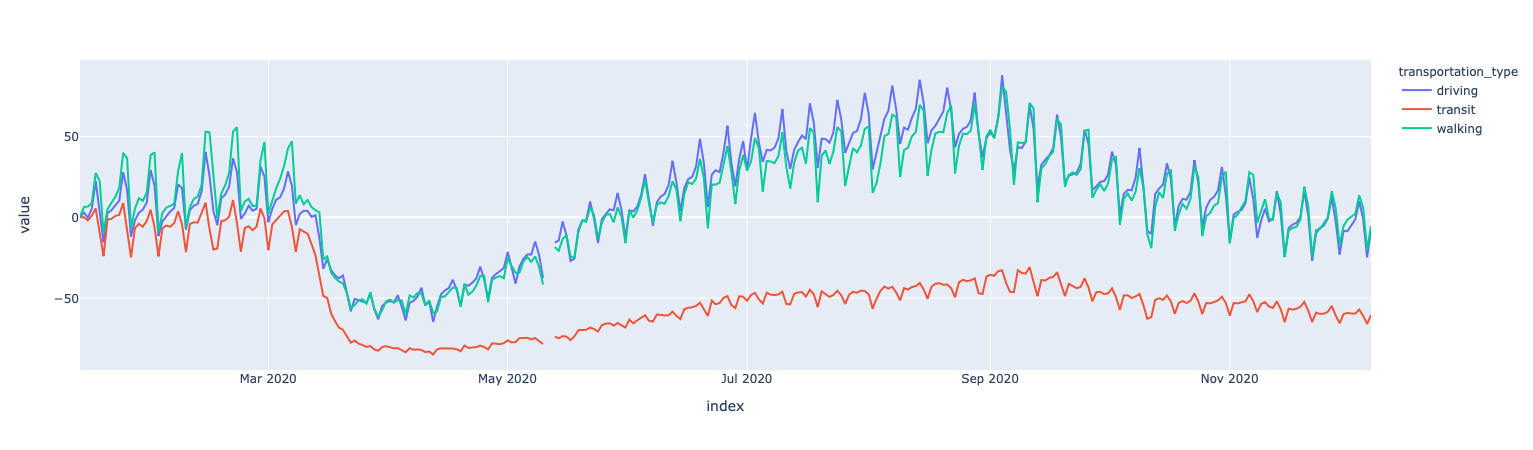

In [6]:
# get trends for Canada
trends_canada = get_country_trend(trends_countries, country_names, country_name = 'Canada')
# visualize data
px.line(trends_canada)

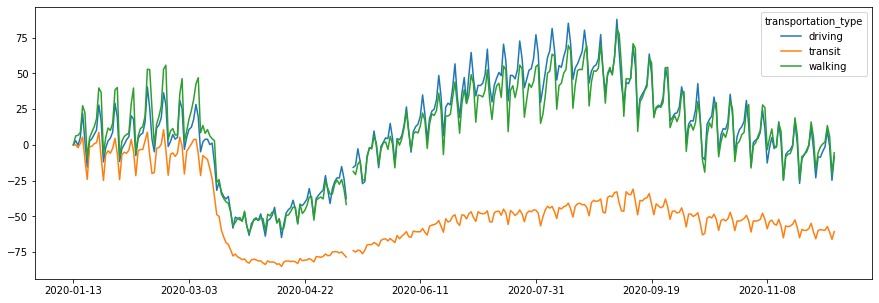

In [7]:
# visualize with matplotlib because plotly doesnt show on GitHub
trends_canada.plot(figsize = (15, 5))

In [16]:
# trends_countries, country_names = clean_data(trends)
# country_names = ['United States', 'Canada']

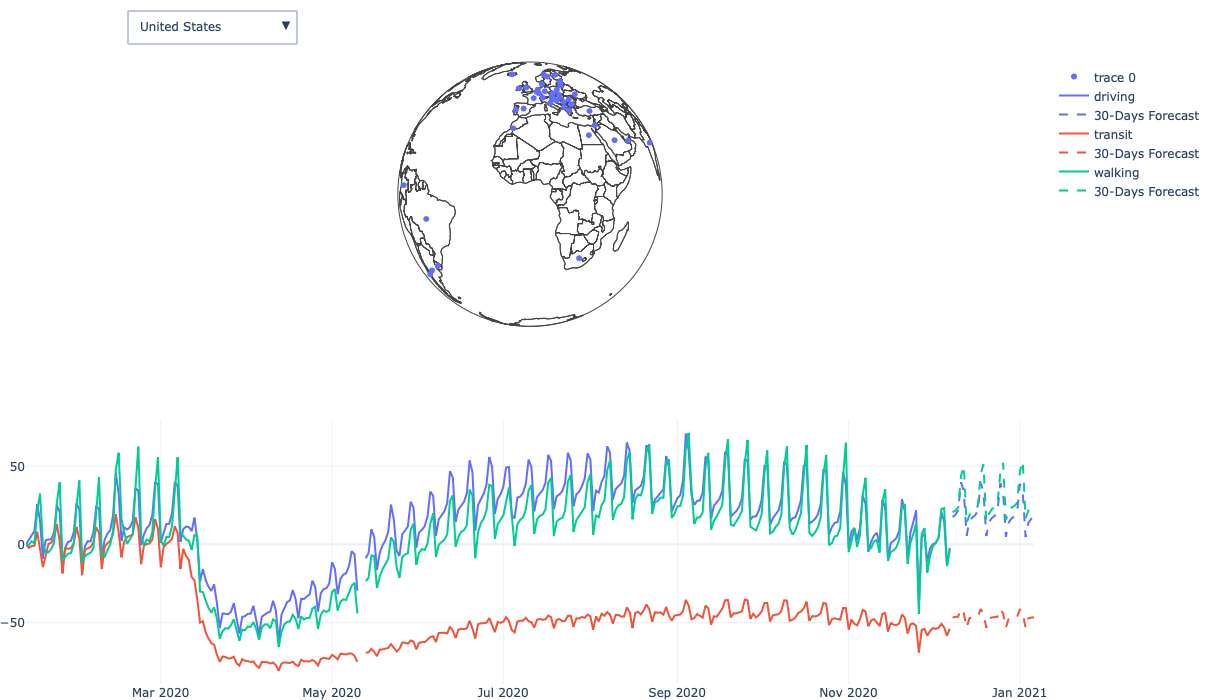

In [13]:
# define default country
default_country = 'United States'
# define lists fort keeping track of added plots and buttons
add_country_plots = []
buttons = []
line_color = ['#636EFA', '#EF553B', '#00CC96']

# create figure
# fig = go.Figure()

###
fig = make_subplots(rows = 2, cols = 2,
                   specs = [
                       [{'type': "scattergeo", "colspan": 2}, None],
                       [{'type': 'scatter', "colspan": 2}, None]
                   ])

fig.add_trace(go.Scattergeo(locations = country_names,
                            locationmode = "country names",
                            marker = dict(line = dict(color = '#636EFA'))),
                            row = 1, col = 1)
###

# add scatter trace for each transportation type and for each country
# loop through country, get corresponding dataframe and projection for each transportation type
for country in country_names:
    # get historical trend
    country_trend = get_country_trend(trends_countries, country_names, country_name = country)    
    # get forecast
    country_forecast = get_country_forecast(forecast_countries, country_names, country_name = country)
    
    # loop through each available transportation type in a country
    for idx, transportation in enumerate(country_trend.columns):
        # add trace of historical trends
        fig.add_trace(go.Scatter(x =country_trend.index, 
                                 y = country_trend[transportation], 
                                 mode = 'lines', 
                                 line = dict(color = line_color[idx]),
                                 name = transportation,
                                 visible = (country == default_country)), # keep default visible only
                      row = 2, col = 1
                     )
        # update lists
        add_country_plots.append(country)
        # add trace of forecasted trends
        fig.add_trace(go.Scatter(x = country_forecast.index,
                                 y = country_forecast[transportation],
                                 line = dict(color = line_color[idx], width = 2, dash='dash'),
                                 mode = 'lines',
                                 name = '30-Days Forecast',
                                 visible = (country == default_country))) # keep default visible only
        # update lists
        add_country_plots.append(country)

# Update plot sizing
fig.update_layout(
    width=1000,
    height=700,
    autosize=False,
    margin=dict(t=0, b=0, l=0, r=1),
    template="plotly_white",
    
    ###
    geo = dict(projection_type = "orthographic",
               showcoastlines=True,
               showcountries = True)
    ###
)

# add button for each country
# loop through country and configure button
# button visibility controls for what trace to appear, correspond to add_country_plots
for country in country_names:
    buttons.append(dict(method='update',
                        label=country,
                        args = [{'visible': [country == c for c in add_country_plots]}]))

# Add dropdown
fig.update_layout(
    updatemenus=[
        dict(
            buttons = buttons,
            direction = "down",
            pad = {"r": 10, "t": 10},
            showactive = True,
            active = list(country_names).index(default_country),
            x = 0.1,
            xanchor = "left",
            y = 1.1,
            yanchor = "top"
        ),
    ]
)

fig.show()

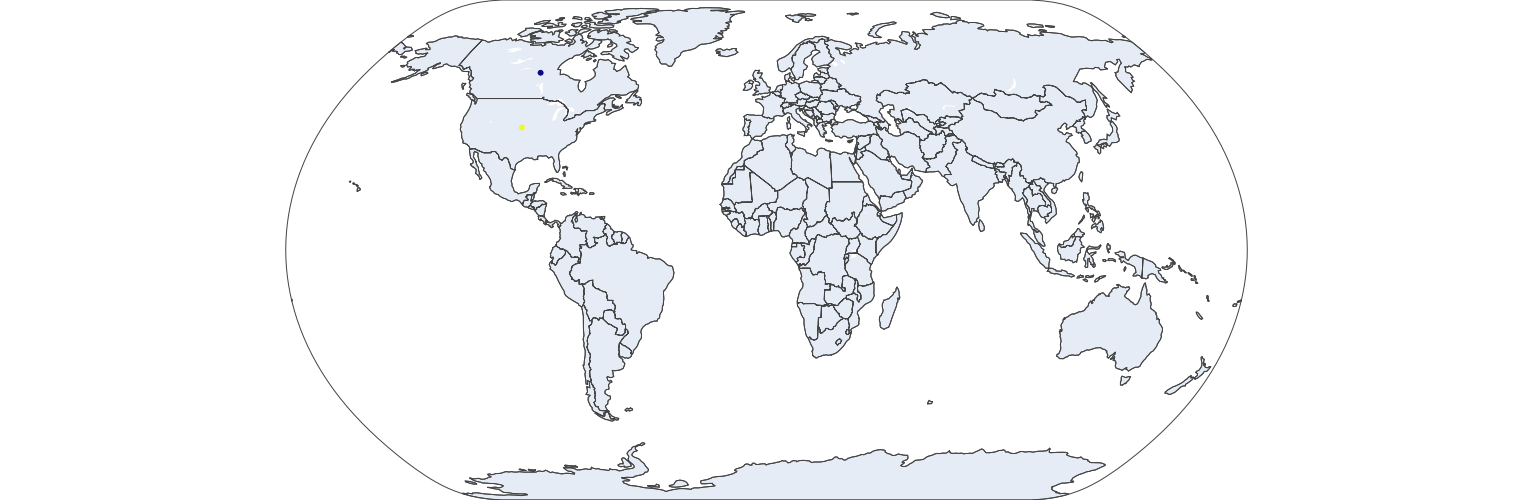

In [14]:
fig = go.Figure(data = go.Scattergeo(locationmode = 'country names',
                                    locations = ['Canada', 'United States'],
                                    mode = 'markers',
                                    marker_color = [1, 2]))
fig.update_geos(projection_type="natural earth",
               showcountries = True)
fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()